In [1]:
#imports
import pandas as pd
import json
import numpy as np

In [2]:
#from https://stackoverflow.com/questions/21058935/python-json-loads-shows-valueerror-extra-data/51830719
#read in json from hydrator
tweets = []
for line in open('../data/harvey_hy.json', 'r'):
    tweets.append(json.loads(line))

In [3]:
#read in csv file of scored tweets
csv_file = pd.DataFrame(pd.read_csv("../data/harvey_scored.csv", sep = ",", header = 0, index_col = False))
#tweetid and label
tweet_id = csv_file[['id','label']]
tweet_id = pd.DataFrame(tweet_id)
#set to dataframe
tweet_id.head()


,id,label
0,901595110210723840,0
1,901595105680916482,2
2,901595104321921025,0
3,901595098626093056,2
4,901595097887686656,1


In [4]:
#from https://stackoverflow.com/questions/35864007/python-3-5-iterate-through-a-list-of-dictionaries
#take gridbox coordinates from json
box = []
for index in range(len(tweets)):
    try:
        for each in tweets[index]['place']['bounding_box']['coordinates']:
            box.append(each)
    # if no coordinates write 0s
    except:
        box.append([[0, 0],[0, 0],[0, 0],[0, 0]])

In [5]:
#from https://docs.python.org/3/tutorial/datastructures.html
# coordinates if tweet has coordinates as a list
cords = []
cd = []
for index in range(len(tweets)):
    cd = []
    try:
        for each in tweets[index]['coordinates']['coordinates']:
            cd.append(each)
        cords.append(cd)
    except:
        cords.append([0,0])
#make cords dataframr        
cords = pd.DataFrame(cords)
cords = cords.rename(columns ={0:'lon_c', 1:'lat_c'})

In [6]:
#get center of the the gridbox for each tweet
latitude = []
longitude = []
for i in range(len(box)):
    lon = (box[i][0][0] + box[i][1][0] + box[i][2][0] + box[i][3][0]) / 4
    lat = (box[i][0][1] + box[i][1][1] + box[i][2][1] + box[i][3][1]) / 4
    latitude.append(lat)
    longitude.append(lon)
    #add to dataframe
    df = pd.DataFrame({'lat_g': latitude, "lon_g":longitude}, columns =['lat_g', 'lon_g']) 

In [7]:
#combine dataframes
points = pd.concat([tweet_id,df,cords], axis=1)


In [8]:
#if tweet has coordinates add to a column 
#if not add the center grid coordinates
var =[]
for item in points['lon_c'].items():
    if item[1] != 0.0:
         var.append(item[1])
    else:
        var.append(points['lon_g'].iloc[item[0]])
#add to a dataframe
var = pd.DataFrame({'lon': var}, columns =['lon']) 


In [9]:
#if tweet has coordinates add to a column 
#if not add the center grid coordinates
var_2 = []
for item in points['lat_c'].items():
    if item[1] != 0.0:
        var_2.append(item[1])
    else:
        var_2.append(points['lat_g'].iloc[item[0]])
#add to a dataframe
var_2 = pd.DataFrame({'lat': var_2}, columns =['lat']) 

In [10]:
#combine to one dataframe
point = pd.concat([points, var, var_2], axis=1)
#export to csv
point.to_csv('./test.csv')
point.head()

,id,label,lat_g,lon_g,lon_c,lat_c,lon,lat
0,901595110210723840,0,0.0,0.0,0.0,0.0,0.0,0.0
1,901595105680916482,2,0.0,0.0,0.0,0.0,0.0,0.0
2,901595104321921025,0,0.0,0.0,0.0,0.0,0.0,0.0
3,901595098626093056,2,0.0,0.0,0.0,0.0,0.0,0.0
4,901595097887686656,1,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
#from https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972
#import
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
%matplotlib inline
crs ={'init': 'epsg:4326'}
file_path = '/Users/russell/Downloads/states_21basic/states.shx'
map_df = gpd.read_file(file_path)


In [12]:
#set points for geopandas
geometry = [Point(xy) for xy in zip(point['lon'], 
                                    point['lat'])]
geo = gpd.GeoDataFrame(point,
                         crs =crs,
                         geometry = geometry)
#remove points with no coordinates
test_df = geo.lon != 0.0
geo_df = geo[test_df]
#check dataframe
geo_df.head()
l_count = geo_df.label.value_counts()
l_count

1    370
0    242
2    221
Name: label, dtype: int64

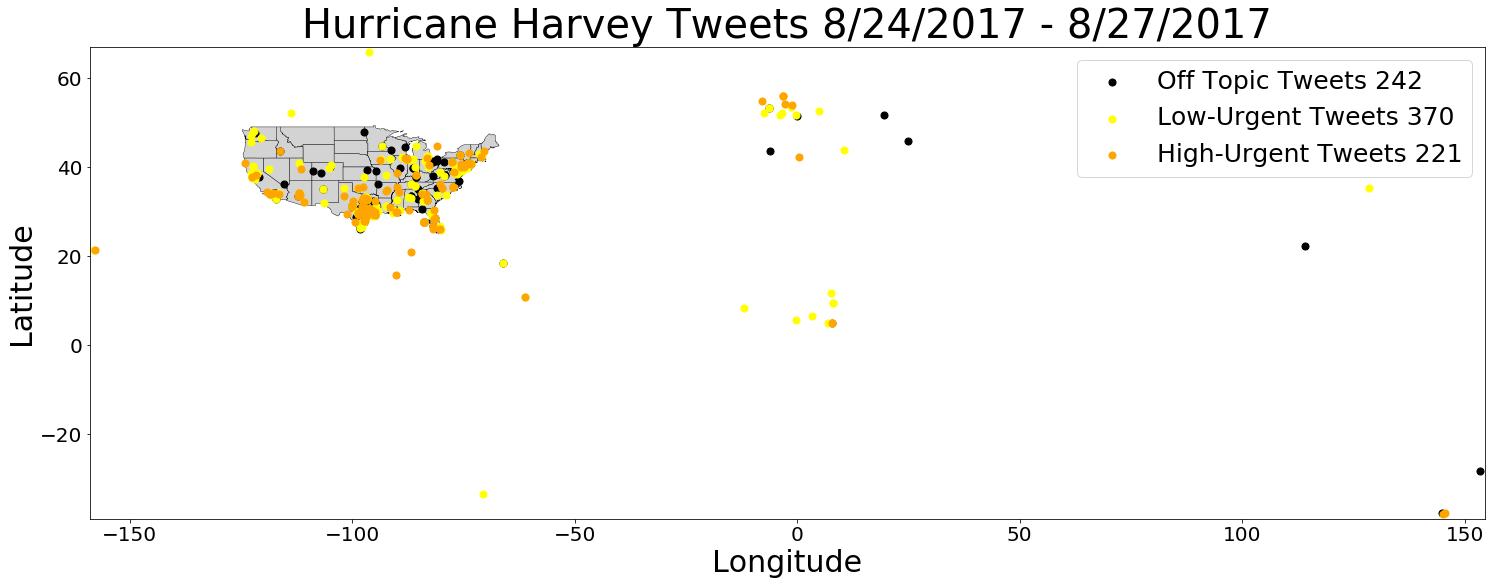

In [13]:
#from

#set up plot
fig, ax = plt.subplots(figsize=(25, 25))
#add US map
#from Nick Minaie
#title
plt.title('Hurricane Harvey Tweets 8/24/2017 - 8/27/2017', size=40)
map_df[(map_df['DRAWSEQ']<51) & (map_df['DRAWSEQ']>=2)].plot(                                                    
             color='lightgray',      # Colormap for the states                     
             linewidth=0.4,      # line width for state borders
             ax=ax,              # plotting the map on 'ax'
             edgecolor='black');
# off topic tweets
geo_df[geo_df['label'] == 0].plot(ax = ax, markersize = 50, color = 'black', marker = 'o', label = f'Off Topic Tweets {l_count[0]}')
# on topic tweets non urgent
geo_df[geo_df['label'] == 1].plot(ax = ax, markersize = 50, color = 'yellow', marker = 'o', label = f'Low-Urgent Tweets {l_count[1]}')
#on topic tweets urgent
geo_df[geo_df['label'] == 2].plot(ax = ax, markersize = 50, color = 'orange', marker = 'o', label = f'High-Urgent Tweets {l_count[2]}')
#set limit of lat and lon
plt.xlim(geo_df['lon'].min()-1.1, geo_df['lon'].max() + 1.1)
plt.ylim(geo_df['lat'].min()-1.1, geo_df['lat'].max() + 1.1)
#axis labels
plt.xlabel('Longitude', size = 30)
plt.ylabel('Latitude', size = 30)
#add legend
plt.xticks(fontsize = 20)
plt.yticks(fontsize =20)
plt.legend(prop = {'size':25})

/Users/russell/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/russell/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


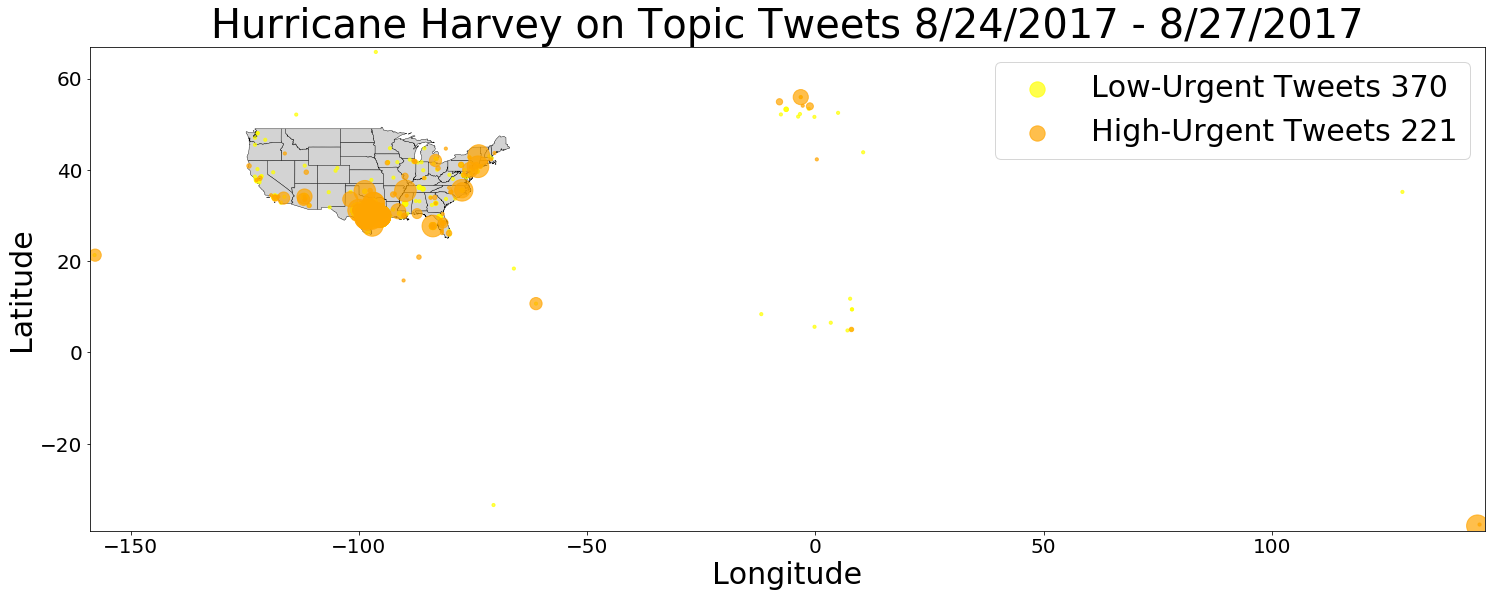

In [14]:
from collections import Counter

#size 2s
two_df = geo_df['label'] == 2
two_df = geo_df[two_df]
# test_df = two_df.lon != 0.0
# two_df = two_df[test_df]
#size 1s
one_df = geo_df['label'] == 1
one_df = geo_df[one_df]
# test_df = one_df.lon != 0.0
# one_df = one_df[test_df]

#https://www.bigendiandata.com/2017-06-27-Mapping_in_Jupyter/
a = two_df['lon']
b = two_df['lat']
count = Counter(zip(a,b))
# create a list of the sizes, here multiplied by 10 for scale
size = [10*count[(aa,bb)] for aa,bb in zip(a,b)]

two_df['size']=size

#https://www.bigendiandata.com/2017-06-27-Mapping_in_Jupyter/
x = one_df['lon'] 
y = one_df['lat']
c = Counter(zip(x,y))
# create a list of the sizes, here multiplied by 10 for scale
s = [10*c[(xx,yy)] for xx,yy in zip(x,y)]
one_df['size'] = s
new_df = pd.concat([one_df, two_df], axis=0)

# merge 1s and 2s
new_df = pd.concat([one_df, two_df], axis=0)
new_df.head()

#plot
fig, ax = plt.subplots(figsize=(25, 25))
plt.title('Hurricane Harvey on Topic Tweets 8/24/2017 - 8/27/2017', size=40)
map_df[(map_df['DRAWSEQ']<51) & (map_df['DRAWSEQ']>=2)].plot(                                                    
             color='lightgray',      # Colormap for the states                     
             linewidth=0.4,      # line width for state borders
             ax=ax,              # plotting the map on 'ax'
             edgecolor='black');
#low-urgent tweets ploted as size = 10xthe number of tweets from that location
new_df[new_df['label'] == 1].plot(ax = ax, markersize = (new_df['size']), color = 'yellow', marker = 'o', alpha ='0.7', label = f'Low-Urgent Tweets {l_count[1]}')
#low-urgent tweets ploted as size = 10xthe number of tweets from that location
new_df[new_df['label'] == 2].plot(ax = ax, markersize = (new_df['size']), color = 'orange', marker = 'o', alpha = '0.7', label = f'High-Urgent Tweets {l_count[2]}')
#set limit of lat and lon
plt.xlim(new_df['lon'].min()-1.1, new_df['lon'].max() + 1.1)
plt.ylim(new_df['lat'].min()-1.1, new_df['lat'].max() + 1.1)
plt.xlabel('Longitude', size = 30)
plt.ylabel('Latitude', size = 30)
#add legend
plt.xticks(fontsize = 20)
plt.yticks(fontsize =20)
plt.legend(prop = {'size':30})

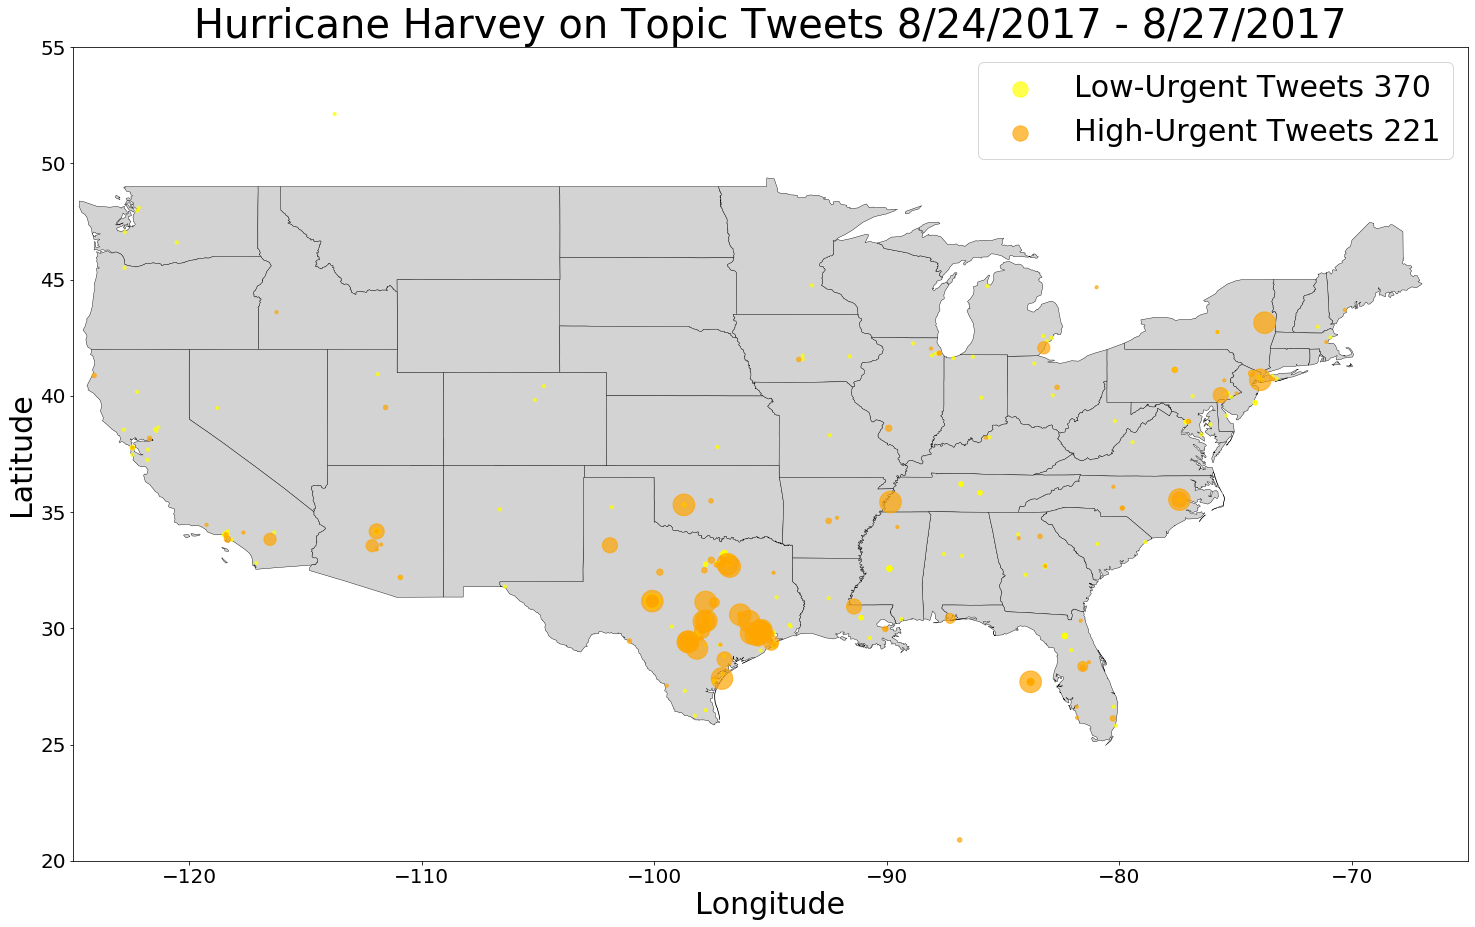

In [23]:
#plot
fig, ax = plt.subplots(figsize=(25, 25))
plt.title('Hurricane Harvey on Topic Tweets 8/24/2017 - 8/27/2017', size=40)
map_df[(map_df['DRAWSEQ']<51) & (map_df['DRAWSEQ']>=2)].plot(                                                    
             color='lightgray',      # Colormap for the states                     
             linewidth=0.4,      # line width for state borders
             ax=ax,              # plotting the map on 'ax'
             edgecolor='black');
#low-urgent tweets ploted as size = 10xthe number of tweets from that location
new_df[new_df['label'] == 1].plot(ax = ax, markersize = (new_df['size']), color = 'yellow', marker = 'o', alpha ='0.7', label = f'Low-Urgent Tweets {l_count[1]}')
#low-urgent tweets ploted as size = 10xthe number of tweets from that location
new_df[new_df['label'] == 2].plot(ax = ax, markersize = (new_df['size']), color = 'orange', marker = 'o', alpha = '0.7', label = f'High-Urgent Tweets {l_count[2]}')
#set limit of lat and lon
plt.xlim(-125,-65)
plt.ylim(20,55)
plt.xlabel('Longitude', size = 30)
plt.ylabel('Latitude', size = 30)
#add legend
plt.xticks(fontsize = 20)
plt.yticks(fontsize =20)
plt.legend(prop = {'size':30})